# Creating Local RAG Pipeline from Scratch

## 1. Data Preparation and Embedding Creation

### 1.1 Importing PDF Document for our Book

In [1]:
import os
import re
import fitz
import random
import requests
import textwrap
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from typing import List, Dict  # for type hints
from spacy.lang.en import English
from transformers.utils import is_flash_attn_2_available
from sentence_transformers import util, SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM

In [2]:
import torch

In [3]:
# getting pdf documents from local system
pdf_path = "/Users/adityamishra/Documents/Machine Learning Tutorial/4. RAG/clrs.pdf"

# download pdf if not present
if not os.path.exists(pdf_path):
    print(f"Given path {pdf_path} does not exist. Downloading the pdf file!!!")
    url = "https://www.cs.mcgill.ca/~akroit/math/compsci/Cormen%20Introduction%20to%20Algorithms.pdf"
    
    filename = pdf_path
    response = requests.get(url)# download the file
    
    if response.status_code == 200: # check if the download was successful
        with open(filename, 'wb') as file:
            file.write(response.content)# save the file
        print(f"File downloaded and saved as {filename}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")
else:
    print(f"File already exists at {pdf_path}. Proceeding to read the file.")

File already exists at /Users/adityamishra/Documents/Machine Learning Tutorial/4. RAG/clrs.pdf. Proceeding to read the file.


Sine now we have imported our file now next step is to preprocess the text as we read it. We have imported the pages of book in the `file_path` and now we can open and read it with `PyMuPDF` by typing command `import fitz`.

In [4]:
def text_formatter(text: str) -> str:
    #fixing hyphenated words split across lines
    text = re.sub(r'(\w+)-\s*\n\s*(\w+)', r'\1\2', text)
    # fixing words split across lines WITHOUT hyphens
    text = re.sub(r'(\w+)\s*\n\s*(\w+)', lambda m: m.group(1) + m.group(2) if m.group(2)[0].islower() else m.group(0), text)
    # preserve code blocks
    lines = text.split('\n')
    processed_lines = []
    in_code_block = False

    for i, line in enumerate(lines):
        stripped = line.strip()
        #skipping empty lines
        if not stripped:
            processed_lines.append('')
            continue

        # checking if code or pseudocode
        is_code_line = (
            len(line) - len(line.lstrip()) >= 4 or  # 4+ space indent
            stripped.startswith('//') or  # comment
            re.match(r'^(if|for|while|return|else)\b', stripped, re.IGNORECASE) or
            re.match(r'^[A-Z][A-Z\-]+\(', stripped)  # FUNCTION-NAME(
        )

        if is_code_line:
            in_code_block = True
            # keeping the line with a marker
            processed_lines.append('__CODELINE__' + line)
        else:
            # checking if we just exited a code block
            if in_code_block:
                processed_lines.append('__CODEEND__')
                in_code_block = False
            processed_lines.append(line)

    text = '\n'.join(processed_lines)

    #paragraph joining for non-code text where we join lines that are part of the same paragraph
    text = re.sub(
        r'(?<!__CODELINE__)(?<!__CODEEND__)(?<!\n)\n(?!__CODELINE__)(?!__CODEEND__)(?!\n)(?![A-Z])', ' ', text)
    #cleaning up markers
    text = text.replace('__CODELINE__', '')
    text = text.replace('__CODEEND__', '\n')
    #removing excessive blank lines (3+) but keep double newlines for sections
    text = re.sub(r'\n{3,}', '\n\n', text)
    #cleaning up multiple spaces (but not at line start - that's indentation)
    text = re.sub(r'([^\n]) {2,}', r'\1 ', text)
    #fixing spacing around punctuation
    text = re.sub(r'\s+([.,;:!?])', r'\1', text)
    #removing standalone page numbers (just digits on their own line)
    text = re.sub(r'^\s*\d{1,4}\s*$', '', text, flags=re.MULTILINE)
    #removing common header and footer patterns
    text = re.sub(r'^(Chapter|Section)\s+\d+.*$', '',
                  text, flags=re.MULTILINE | re.IGNORECASE)
    text = text.strip()
    return text

#detecting block of algorithm in clrs
def is_algorithm_block(text: str) -> bool:
    indicators = [
        bool(re.search(r'\b(if|then|else)\b', text, re.IGNORECASE)),
        bool(re.search(r'\b(for|while|do)\b', text, re.IGNORECASE)),
        bool(re.search(r'\breturn\b', text, re.IGNORECASE)),
        bool(re.search(r'^\s*//.*', text, re.MULTILINE)),  # comments
        bool(re.search(r'[A-Z][A-Z\-]+\([^)]*\)', text)),  # FUNCTION(...)
        bool(re.search(r'A\[\s*\d+', text)),  # Array notation A[1]
        bool(re.search(r'←|:=|=', text)),  # Assignment operators
    ]
    # Need at least 2 indicators and text should be substantial
    return sum(indicators) >= 2 and len(text.split()) > 10

#section header text
def is_section_header(text: str) -> bool:
    text = text.strip()
    if not text or len(text) > 100:
        return False

    words = text.split()
    if len(words) > 15 or len(words) < 2:
        return False
    # Skip table of contents entries (have lots of dots)
    if text.count('.') > 3:
        return False
    # Skip if it's just "Contents" or roman numerals
    if text.lower() in ['contents', 'preface', 'index', 'references']:
        return False
    # Likely a header if it doesn't end with period and isn't too long
    return not text.endswith('.')

#detecting table of contents
def is_toc_or_front_matter(text: str) -> bool:
    indicators = [
        'contents' in text.lower()[:50],
        'preface' in text.lower()[:50],
        text.count('...') > 2,  # TOC dots
        # Too many periods (TOC page numbers)
        text.count('.') > len(text.split()) * 0.5,
        # Roman numerals only
        bool(re.search(r'^[ivxlcdm]+$', text.strip(), re.IGNORECASE)),
    ]
    return any(indicators) or len(text.split()) < 5

#preserving chunk for contexts
def smart_chunker(pages_and_texts: List[Dict],
                  chunk_size: int = 1000,
                  overlap: int = 200,
                  skip_front_matter: bool = True) -> List[Dict]:
    chunks = []

    for page_data in pages_and_texts:
        text = page_data['text']
        page_num = page_data['page_number']

        # Skip if this looks like front matter
        if skip_front_matter and is_toc_or_front_matter(text):
            continue
        # Skip very short pages (likely artifacts)
        if len(text.split()) < 10:
            continue
        # Split by double newlines to get paragraphs/blocks
        blocks = re.split(r'\n\n+', text)

        current_chunk = ""
        current_chunk_metadata = {
            'page_number': page_num,
            'has_algorithm': False,
            'section_header': None
        }
        for block in blocks:
            block = block.strip()
            if not block or len(block) < 10:
                continue
            if is_section_header(block):# if we have a current chunk, save it
                if current_chunk and len(current_chunk.split()) > 10:
                    chunks.append({
                        'text': current_chunk.strip(),
                        'page_number': current_chunk_metadata['page_number'],
                        'chunk_char_count': len(current_chunk),
                        'chunk_word_count': len(current_chunk.split()),
                        'chunk_token_count': len(current_chunk) / 4,
                        'has_algorithm': current_chunk_metadata['has_algorithm'],
                        'section_header': current_chunk_metadata['section_header']
                    })

                # Start new chunk with this header
                current_chunk = block + "\n\n"
                current_chunk_metadata = {
                    'page_number': page_num,
                    'has_algorithm': False,
                    'section_header': block
                }
                continue

            # Check if this is an algorithm block
            block_has_algo = is_algorithm_block(block)
            if block_has_algo:
                current_chunk_metadata['has_algorithm'] = True

                # If adding this would exceed chunk_size significantly and we have content, save current chunk
                if len(current_chunk) + len(block) > chunk_size * 1.5 and len(current_chunk.split()) > 20:
                    chunks.append({
                        'text': current_chunk.strip(),
                        'page_number': current_chunk_metadata['page_number'],
                        'chunk_char_count': len(current_chunk),
                        'chunk_word_count': len(current_chunk.split()),
                        'chunk_token_count': len(current_chunk) / 4,
                        'has_algorithm': current_chunk_metadata['has_algorithm'],
                        'section_header': current_chunk_metadata['section_header']
                    })

                    # Start new chunk with overlap from previous
                    if len(current_chunk) > overlap:
                        # Get more than we need to find clean word boundary
                        overlap_start = max(
                            0, len(current_chunk) - overlap - 50)
                        overlap_text = current_chunk[overlap_start:]
                        # Find first complete word (space followed by word followed by space)
                        match = re.search(r'\s+(\S+\s+)', overlap_text)
                        if match:
                            # Start from the beginning of that complete word
                            overlap_text = overlap_text[match.start(1):]
                        else:
                            # Fallback: just find first space
                            space_idx = overlap_text.find(' ')
                            if space_idx > 0:
                                overlap_text = overlap_text[space_idx+1:]
                    else:
                        overlap_text = current_chunk
                    current_chunk = overlap_text + "\n\n" + block + "\n\n"
                    current_chunk_metadata = {
                        'page_number': page_num,
                        'has_algorithm': True,
                        'section_header': current_chunk_metadata['section_header']
                    }
                else:
                    # Add algorithm block to current chunk (keep it together!)
                    current_chunk += block + "\n\n"
            else:
                # Regular text block
                if len(current_chunk) + len(block) > chunk_size and len(current_chunk.split()) > 20:
                    # Save current chunk
                    chunks.append({
                        'text': current_chunk.strip(),
                        'page_number': current_chunk_metadata['page_number'],
                        'chunk_char_count': len(current_chunk),
                        'chunk_word_count': len(current_chunk.split()),
                        'chunk_token_count': len(current_chunk) / 4,
                        'has_algorithm': current_chunk_metadata['has_algorithm'],
                        'section_header': current_chunk_metadata['section_header']
                    })

                    # Start new chunk with overlap
                    if len(current_chunk) > overlap:
                        # Find word boundary for clean overlap
                        overlap_text = current_chunk[-overlap:]
                        # Adjust to start at word boundary
                        space_idx = overlap_text.find(' ')
                        if space_idx > 0:
                            overlap_text = overlap_text[space_idx+1:]
                    else:
                        overlap_text = current_chunk
                    current_chunk = overlap_text + "\n\n" + block + "\n\n"
                    current_chunk_metadata = {
                        'page_number': page_num,
                        'has_algorithm': False,
                        'section_header': current_chunk_metadata['section_header']
                    }
                else:
                    current_chunk += block + "\n\n"

        # Save the last chunk from this page if it's substantial
        if current_chunk.strip() and len(current_chunk.split()) > 10:
            chunks.append({
                'text': current_chunk.strip(),
                'page_number': current_chunk_metadata['page_number'],
                'chunk_char_count': len(current_chunk),
                'chunk_word_count': len(current_chunk.split()),
                'chunk_token_count': len(current_chunk) / 4,
                'has_algorithm': current_chunk_metadata['has_algorithm'],
                'section_header': current_chunk_metadata['section_header']
            })

    # Add chunk IDs
    for i, chunk in enumerate(chunks):
        chunk['chunk_id'] = i

    return chunks

In [5]:
def open_and_read_pdf(pdf_path: str, page_offset: int = 0) -> List[Dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc), desc="Reading PDF pages", total=len(doc)):
        text = page.get_text()
        text = text_formatter(text)
        # Skip completely empty pages
        if not text.strip():
            continue
        pages_and_texts.append({
            "page_number": page_number - page_offset,
            "pdf_page_number": page_number,  # Keep original for reference
            "page_char_count": len(text),
            "page_word_count": len(text.split()),
            "page_sentence_count_raw": len(text.split(". ")),
            "page_token_count": len(text) / 4,
            "text": text
        })

    return pages_and_texts

def find_content_start_page(pdf_path: str, sample_size: int = 50) -> int:
    doc = fitz.open(pdf_path)
    for page_num in range(min(sample_size, len(doc))):
        page = doc[page_num]
        text = page.get_text()

        #looking for indicators of actual content like chapter 1 and introduction etc.
        if re.search(r'chapter\s+1|^1\s+introduction', text, re.IGNORECASE | re.MULTILINE):
            print(f"Found likely content start at PDF page {page_num}")
            print(f"First 200 chars: {text[:200]}")
            return page_num

    print("Could not automatically find content start. Please check manually.")
    return 0

In [6]:
content_start = find_content_start_page(pdf_path)
pages_and_texts = open_and_read_pdf(pdf_path, page_offset=41)
chunks = smart_chunker(pages_and_texts, chunk_size=1000,
                       overlap=200, skip_front_matter=True)
print(f"Total pages: {len(pages_and_texts)}")
print(f"Total chunks: {len(chunks)}")
print(
    f"Chunks with algorithms: {sum(1 for c in chunks if c['has_algorithm'])}")
for i in range(50, 53):
    print(f"\n{'='*60}")
    print(f"Chunk {i}:")
    print(
        f"Page: {chunks[i]['page_number']}, Has algo: {chunks[i]['has_algorithm']}")
    print(f"Header: {chunks[i]['section_header']}")
    print(f"Text preview: {chunks[i]['text'][:300]}...")

Found likely content start at PDF page 23
First 200 chars: Introduction
This part will start you thinking about designing and analyzing algorithms. It is
intended to be a gentle introduction to how we specify algorithms, some of the
design strategies we will 


Reading PDF pages:   0%|          | 0/1313 [00:00<?, ?it/s]

Total pages: 1306
Total chunks: 1931
Chunks with algorithms: 1260

Chunk 50:
Page: 14, Has algo: True
Header: None
Text preview: 2.3
Designing algorithms 35 5 2 4 7 1 3 2 6 2 5 4 7 1 3 2 6 2 4 5 7 1 2 3 6 1 2 2 3 4 5 6 7 mergemerge mergesorted sequenceinitial sequencemerge mergemerge merge
Figure 2.4
The operation of merge sort on the array A D h5; 2; 4; 7; 1; 3; 2; 6i. The lengths of thesorted sequences being merged increase...

Chunk 51:
Page: 15, Has algo: True
Header: None
Text preview: Getting Startedthe original problem size is a power of 2. Each divide step then yields two subsequences of size exactly n=2. In Chapter 4, we shall see that this assumption doesnot affect the order of growth of the solution to the recurrence.
We reason as follows to set up the recurrence for T.n/, t...

Chunk 52:
Page: 15, Has algo: True
Header: 2T.n=2/ C ‚.n/
if n > 1:
Text preview: 2T.n=2/ C ‚.n/
if n > 1:

(2.1)
In Chapter 4, we shall see the “master theorem,” which we can use to showthat T.n/ is

In [7]:
random.sample(pages_and_texts, k=3)# finding random text from random pages

[{'page_number': 463,
  'pdf_page_number': 504,
  'page_char_count': 1674,
  'page_word_count': 273,
  'page_sentence_count_raw': 13,
  'page_token_count': 418.5,
  'text': 'B-Trees\nB-trees are balanced search trees designed to work well on disks or other directaccess secondary storage devices. B-trees are similar to red-black trees (Chapter 13), but they are better at minimizing disk I/O operations. Many database systems use B-trees, or variants of B-trees, to store information.\nB-trees differ from red-black trees in that B-tree nodes may have many children, from a few to thousands. That is, the “branching factor” of a B-tree can be quitelarge, although it usually depends on characteristics of the disk unit used. B-treesare similar to red-black trees in that every n-node B-tree has height O.lg n/. Theexact height of a B-tree can be considerably less than that of a red-black tree, however, because its branching factor, and hence the base of the logarithm thatexpresses its height, can

### 1.2 Getting Text Statistics


In [8]:
df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,pdf_page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,0,189,92,4,47.25,A L G O R I T H M S\nI N T R O D U C T I O N T...
1,-40,1,40,5,1,10.00,Introduction to Algorithms\nThird Edition
2,-38,3,165,23,4,41.25,Thomas H. Cormen\nCharles E. Leiserson\nRonald...
3,-37,4,883,127,13,220.75,c 2009 Massachusetts Institute of Technology\n...
4,-36,5,876,134,1,219.00,Contents\nPreface xiii\nI\nFoundations\nIntrod...


In [9]:
df.describe().round(2)# getting basic statistics of the dataframe

,page_number,pdf_page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1306.00,1306.00,1306.00,1306.00,1306.00,1306.00
mean,615.66,656.66,1886.35,333.99,13.02,471.59
std,378.27,378.27,562.75,94.74,9.72,140.69
min,-41.00,0.00,13.00,2.00,1.00,3.25
25%,288.25,329.25,1547.25,279.00,9.00,386.81
50%,615.50,656.50,1918.00,339.00,12.00,479.50
75%,942.75,983.75,2282.25,396.00,15.00,570.56
max,1271.00,1312.00,3225.00,570.00,103.00,806.25


### 1.3 Splitting Pages into Sentences

In [10]:
nlp = English()
nlp.add_pipe("sentencizer")
# making a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2
#Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

In [11]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)# extracting sentences using spacy
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]# Make sure all sentences are strings      
    # counting the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1306 [00:00<?, ?it/s]

In [12]:
random.sample(pages_and_texts, k=1)

[{'page_number': 1022,
  'pdf_page_number': 1063,
  'page_char_count': 1679,
  'page_word_count': 334,
  'page_sentence_count_raw': 9,
  'page_token_count': 419.75,
  'text': '33.4\nFinding the closest pair of points 1043\n\nYL:length D YR:length D 0 3\nfor i D 1 to Y:length\n\nif Y Œi\x8d 2 PL\n\nYL:length D YL:length C 1 6\nYLŒYL:length\x8d D Y Œi\x8d 7else YR:length D YR:length C 1 8\nYRŒYR:length\x8d D Y Œi\x8d\nWe simply examine the points in array Y in order. If a point Y Œi\x8d is in PL, weappend it to the end of array YL; otherwise, we append it to the end of array YR.\nSimilar pseudocode works for forming arrays XL, XR, and Y 0.\nThe only remaining question is how to get the points sorted in the ﬁrst place. Wepresort them; that is, we sort them once and for all before the ﬁrst recursive call.\nWe pass these sorted arrays into the ﬁrst recursive call, and from there we whittlethem down through the recursive calls as necessary. Presorting adds an additional\nO.n lg n/ term to th

In [13]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)# getting basic statistics of the dataframe

,page_number,pdf_page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1306.00,1306.00,1306.00,1306.00,1306.00,1306.00,1306.00
mean,615.66,656.66,1886.35,333.99,13.02,471.59,14.41
std,378.27,378.27,562.75,94.74,9.72,140.69,7.97
min,-41.00,0.00,13.00,2.00,1.00,3.25,1.00
25%,288.25,329.25,1547.25,279.00,9.00,386.81,10.00
50%,615.50,656.50,1918.00,339.00,12.00,479.50,14.00
75%,942.75,983.75,2282.25,396.00,15.00,570.56,17.00
max,1271.00,1312.00,3225.00,570.00,103.00,806.25,68.00


### 1.4 Splitting Sentences

The purpose of splitting our texts into smaller groups is that we want them to fit into our embedding model context window which is having 384 tokens limit.

In [14]:
num_sentence_chunk_size = 10# setting chunk size for sentences
print(f"Sentence chunk size set to: {num_sentence_chunk_size}")

#creating function to split text into sentence chunks
def split_list(input_list: list[str], slice_size:int = num_sentence_chunk_size) -> list[list[str]]:    
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)

Sentence chunk size set to: 10


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [15]:
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1306 [00:00<?, ?it/s]

In [16]:
random.sample(pages_and_texts, k=1)# getting random sample of sentence chunks

[{'page_number': 470,
  'pdf_page_number': 511,
  'page_char_count': 1825,
  'page_word_count': 306,
  'page_sentence_count_raw': 10,
  'page_token_count': 456.25,
  'text': '18.2\nBasic operations on B-trees 491 18.1-3\nShow all legal B-trees of minimum degree 2 that represent f1; 2; 3; 4; 5g. 18.1-4\nAs a function of the minimum degree t, what is the maximum number of keys thatcan be stored in a B-tree of height h? 18.1-5\nDescribe the data structure that would result if each black node in a red-black treewere to absorb its red children, incorporating their children with its own. 18.2\nBasic operations on B-trees\nIn this section, we present the details of the operations B-TREE-SEARCH, BTREE-CREATE, and B-TREE-INSERT. In these procedures, we adopt two conventions: \x0f\nThe root of the B-tree is always in main memory, so that we never need toperform a DISK-READ on the root; we do have to perform a DISK-WRITE ofthe root, however, whenever the root node is changed. \x0f\nAny nodes that

In [17]:
df = pd.DataFrame(pages_and_texts)# creating dataframe
df.describe().round(2)# getting basic statistics of the dataframe

,page_number,pdf_page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1306.00,1306.00,1306.00,1306.00,1306.00,1306.00,1306.00,1306.00
mean,615.66,656.66,1886.35,333.99,13.02,471.59,14.41,1.89
std,378.27,378.27,562.75,94.74,9.72,140.69,7.97,0.83
min,-41.00,0.00,13.00,2.00,1.00,3.25,1.00,1.00
25%,288.25,329.25,1547.25,279.00,9.00,386.81,10.00,1.00
50%,615.50,656.50,1918.00,339.00,12.00,479.50,14.00,2.00
75%,942.75,983.75,2282.25,396.00,15.00,570.56,17.00,2.00
max,1271.00,1312.00,3225.00,570.00,103.00,806.25,68.00,7.00


### 1.5 Splitting Each Partition into an Item

In [18]:
pages_and_chunks = []# list to hold page and chunk information
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}# dictionary to hold chunk information
        chunk_dict["page_number"] = item["page_number"]# page number

        joined_sentence_chunk = "".join(
            sentence_chunk).replace("  ", " ").strip()# Join the sentences together into a paragraph-like structure as  chunk (so they are a single string)
        # ".A" -> ". A" for any full-stop/capital letter combo
        joined_sentence_chunk = re.sub(
            r'\.([A-Z])', r'. \1', joined_sentence_chunk)
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len(
            [word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(
            joined_sentence_chunk) / 4  # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1306 [00:00<?, ?it/s]

2472

In [22]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 136,
  'sentence_chunk': '6.3\nBuilding a heap 157 a 1-element heap to begin with. The procedure BUILD-MAX-HEAP goes throughthe remaining nodes of the tree and runs MAX-HEAPIFY on each one.\nBUILD-MAX-HEAP. A/ 1\nA:heap-size D A:length 2\nfor i D bA:length=2c downto 1\n\nMAX-HEAPIFY. A; i/\nFigure 6.3 shows an example of the action of BUILD-MAX-HEAP.\nTo show why BUILD-MAX-HEAP works correctly, we use the following loopinvariant:\nAt the start of each iteration of the for loop of lines 2–3, each node i C 1; i C 2;:::; n is the root of a max-heap.\nWe need to show that this invariant is true prior to the ﬁrst loop iteration, that eachiteration of the loop maintains the invariant, and that the invariant provides a usefulproperty to show correctness when the loop terminates.\nInitialization: Prior to the ﬁrst iteration of the loop, i D bn=2c. Each nodebn=2c C 1; bn=2c C 2;:::; n is a leaf and is thus the root of a trivial max-heap.\nMaintenance: To see that each iteration

In [24]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,2472.00,2472.00,2472.00,2472.00
mean,649.99,995.77,169.32,248.94
std,391.42,511.97,94.10,127.99
min,-41.00,4.00,1.00,1.00
25%,317.75,569.50,86.00,142.38
50%,648.50,1033.00,172.00,258.25
75%,1001.25,1361.00,235.00,340.25
max,1271.00,2559.00,491.00,639.75


In [25]:
chunks_over_512 = df[df['chunk_token_count'] > 512].shape[0]
percentage = (chunks_over_512 / 2472) * 100

In [26]:
print(f"Number of chunks over 512 tokens: {chunks_over_512} ({percentage:.2f}%)")

Number of chunks over 512 tokens: 45 (1.82%)


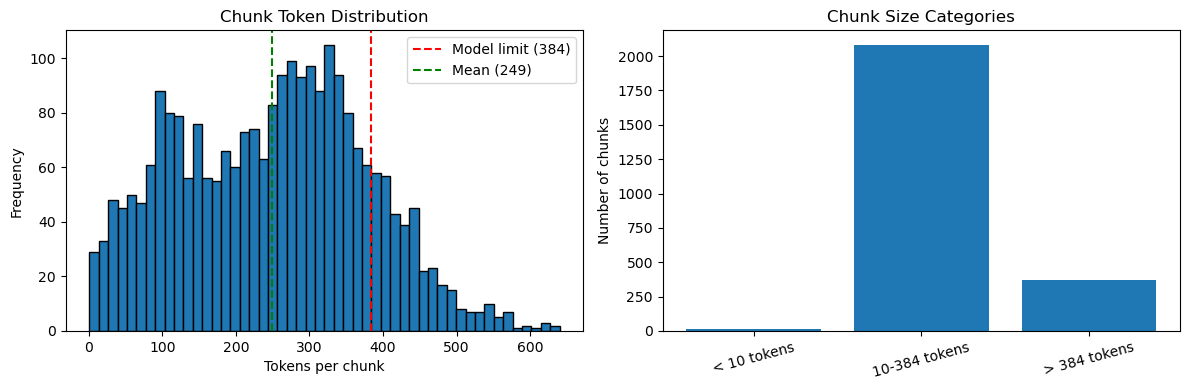


Chunk Analysis:
  Total chunks: 2472
  Too small (< 10 tokens): 17 (0.7%)
  Perfect size (10-384): 2083 (84.3%)
  Too large (> 384): 372 (15.0%)


In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

# Token count distribution
plt.subplot(1, 2, 1)
plt.hist(df['chunk_token_count'], bins=50, edgecolor='black')
plt.axvline(x=384, color='red', linestyle='--', label='Model limit (384)')
plt.axvline(x=df['chunk_token_count'].mean(), color='green',
            linestyle='--', label=f'Mean ({df["chunk_token_count"].mean():.0f})')
plt.xlabel('Tokens per chunk')
plt.ylabel('Frequency')
plt.title('Chunk Token Distribution')
plt.legend()

# Check problematic chunks
plt.subplot(1, 2, 2)
sizes = ['< 10 tokens', '10-384 tokens', '> 384 tokens']
counts = [
    len(df[df['chunk_token_count'] < 10]),
    len(df[(df['chunk_token_count'] >= 10) & (df['chunk_token_count'] <= 384)]),
    len(df[df['chunk_token_count'] > 384])
]
plt.bar(sizes, counts)
plt.ylabel('Number of chunks')
plt.title('Chunk Size Categories')
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

print(f"\nChunk Analysis:")
print(f"  Total chunks: {len(df)}")
print(f"  Too small (< 10 tokens): {counts[0]} ({counts[0]/len(df)*100:.1f}%)")
print(f"  Perfect size (10-384): {counts[1]} ({counts[1]/len(df)*100:.1f}%)")
print(f"  Too large (> 384): {counts[2]} ({counts[2]/len(df)*100:.1f}%)")

In [29]:
print(f"Using all {len(chunks)} chunks")
print("Model will auto-truncate 372 large chunks")

Using all 1931 chunks
Model will auto-truncate 372 large chunks


In [31]:
df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,-41,A L G O R I T H M S\nI N T R O D U C T I O N T...,189,85,47.25
1,-40,Introduction to Algorithms\nThird Edition,40,4,10.00
2,-38,Thomas H. Cormen\nCharles E. Leiserson\nRonald...,165,15,41.25
3,-37,c 2009 Massachusetts Institute of Technology\n...,742,93,185.50
4,-37,alk.paper) 1. Computer programming.2. Computer...,137,22,34.25


In [32]:
min_token_length = 15# setting minimum token length
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():# iterating through rows with chunk token count less than or equal to minimum token length
    print(
        f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 12.75 | Text: Then, using matrix algebra (verify the equations by
Chunk token count: 8.25 | Text: The input text is a sequence of n
Chunk token count: 9.5 | Text: VIII
Appendix: Mathematical Background
Chunk token count: 14.25 | Text: We shall investigate multithreaded algorithms written for
Chunk token count: 14.75 | Text: Perform the inverse of the permutation performed in step 2.


In [33]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -41,
  'sentence_chunk': 'A L G O R I T H M S\nI N T R O D U C T I O N T O\nT H I R D E D I T I O N\nT H O M A S H. \nC H A R L E S E. \nR O N A L D L. \nC L I F F O R D\nS T E I N\nR I V E S T\nL E I S E R S O N\nC O R M E N',
  'chunk_char_count': 189,
  'chunk_word_count': 85,
  'chunk_token_count': 47.25},
 {'page_number': -38,
  'sentence_chunk': 'Thomas H. Cormen\nCharles E. Leiserson\nRonald L. Rivest\nClifford Stein\nIntroduction to Algorithms\nThird Edition\nThe MIT Press\nCambridge, Massachusetts\nLondon, England',
  'chunk_char_count': 165,
  'chunk_word_count': 15,
  'chunk_token_count': 41.25}]

In [34]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': -1,
  'sentence_chunk': 'Getting Startedwe prefer not to get bogged down in such formalism, and so we rely on ourinformal analysis to show that the second property holds for the outer loop.\nTermination: Finally, we examine what happens when the loop terminates. Thecondition causing the for loop to terminate is that j > A:length D n. Becauseeach loop iteration increases j by 1, we must have j D n C 1 at that time.\nSubstituting n C 1 for j in the wording of loop invariant, we have that thesubarray AŒ1:: n\x8d consists of the elements originally in AŒ1:: n\x8d, but in sortedorder. Observing that the subarray AŒ1:: n\x8d is the entire array, we conclude thatthe entire array is sorted. Hence, the algorithm is correct.\nWe shall use this method of loop invariants to show correctness later in thischapter and in other chapters as well.\nPseudocode conventions\nWe use the following conventions in our pseudocode.\x0f\nIndentation indicates block structure. For example, the bod